# Alphabet Soup's Charity Risk Assessment

Alphabet Soup is a fictional nonprofit foundation that makes donations to various organizations that aim to make the world a better place by protecting the environment, improving people's well-being, etc. Unfortunately, not every investment by the foundation is impactful. The goal of this project is to come up with a data-driven solution to help ensure that the foundation's money is going to organizations that are worth donating to. The solution is to build a model to assess an organization's risk before donating to them.

### Dependencies and data

In [1]:
# Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras

/Users/tribui/miniconda3/envs/minds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tribui/miniconda3/envs/minds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tribui/miniconda3/envs/minds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tribui/miniconda3/envs/minds/lib/pyt

In [2]:
# Data
df = pd.read_csv('data/charity_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   EIN                     34299 non-null  int64 
 1   NAME                    34299 non-null  object
 2   APPLICATION_TYPE        34299 non-null  object
 3   AFFILIATION             34299 non-null  object
 4   CLASSIFICATION          34299 non-null  object
 5   USE_CASE                34299 non-null  object
 6   ORGANIZATION            34299 non-null  object
 7   STATUS                  34299 non-null  int64 
 8   INCOME_AMT              34299 non-null  object
 9   SPECIAL_CONSIDERATIONS  34299 non-null  object
 10  ASK_AMT                 34299 non-null  int64 
 11  IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 3.1+ MB


In [3]:
df.head(3)

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


### Numeric features

In [4]:
# Unique value counts
df.nunique()

EIN                       34299
NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [5]:
# Inspect integer columns
df.describe()

,EIN,STATUS,ASK_AMT,IS_SUCCESSFUL
count,3.429900e+04,34299.000000,3.429900e+04,34299.000000
mean,5.191852e+08,0.999854,2.769199e+06,0.532406
std,2.451472e+08,0.012073,8.713045e+07,0.498956
min,1.052060e+07,0.000000,5.000000e+03,0.000000
25%,2.748482e+08,1.000000,5.000000e+03,0.000000
50%,4.656317e+08,1.000000,5.000000e+03,1.000000
75%,7.526117e+08,1.000000,7.742000e+03,1.000000
max,9.960869e+08,1.000000,8.597806e+09,1.000000


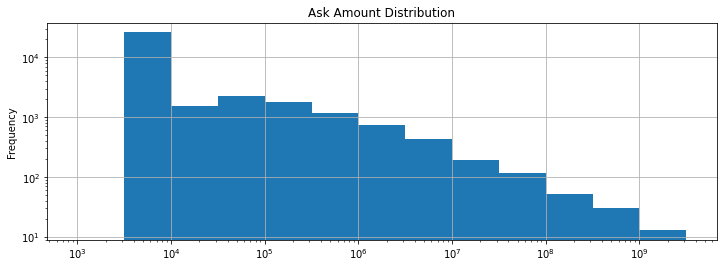

In [6]:
# Inspect `ASK_AMT`
ask = df['ASK_AMT']
ask.plot(kind='hist', bins=10**np.arange(3, 10, 0.5), grid=True, figsize=(12, 4), title='Ask Amount Distribution')
plt.yscale('log')
plt.xscale('log')
plt.show()

### Categorical features

In [7]:
# Rename columns
df.columns = ['ein', 'name', 'application_type', 'affiliation', 'classification', 'use', 
              'organization', 'active', 'income', 'special_considerations', 'amount', 'successful']
df.head(3)

,ein,name,application_type,affiliation,classification,use,organization,active,income,special_considerations,amount,successful
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0


In [8]:
# Unique value counts for categorical columns
cat_feats = df.dtypes[df.dtypes == object].index.tolist()
df[cat_feats].nunique()

name                      19568
application_type             17
affiliation                   6
classification               71
use                           5
organization                  4
income                        9
special_considerations        2
dtype: int64

In [10]:
# Inspect the top 10 labels of `classification` and `application_type`
print(df['classification'].value_counts()[:10])
df['application_type'].value_counts()[:10]

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
Name: classification, dtype: int64


T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
Name: application_type, dtype: int64

In [11]:
# Inspect labels of all other categorical features
for feat in [cat_feats[2]] + cat_feats[4:]:
    print(df[feat].value_counts())

Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: affiliation, dtype: int64
Preservation     28095
ProductDev        5671
CommunityServ      384
Heathcare          146
Other                3
Name: use, dtype: int64
Trust           23515
Association     10255
Co-operative      486
Corporation        43
Name: organization, dtype: int64
0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: income, dtype: int64
N    34272
Y       27
Name: special_considerations, dtype: int64


In [12]:
# Reduce `classification` to the top 3 and an other label
df['classification'] = df['classification'].apply(lambda c: c if c in ['C1000', 'C2000', 'C1200'] else '0ther')

# Create a dichotomous feature indicating whether the `application_type` is T3
df['application_T3'] = (df['application_type'] == 'T3').astype(int)

df.head(3)

,ein,name,application_type,affiliation,classification,use,organization,active,income,special_considerations,amount,successful,application_T3
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1,0
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,0ther,ProductDev,Association,1,0,N,5000,0,0


In [13]:
# Create a feature reducing `affiliation` to the top 2 and an "_other" label
df['affiliation'] = df['affiliation'].apply(lambda a: a if a in ['Independent', 'CompanySponsored'] else '0ther')

# Create a feature reducing `use` to the top 2 and an "_other" label
df['use'] = df['use'].apply(lambda a: a if a in ['Preservation', 'ProductDev'] else '0ther')

# Create a feature reducing `organization` to the top 2 and an "_other" label
df['organization'] = df['organization'].apply(lambda a: a if a in ['Trust', 'Association'] else '0ther')

# Create a dichotomous feature indicating whether there were `special_considerations`
df['special'] = (df['special_considerations'] == 'Y').astype(int)

df.head(3)

,ein,name,application_type,affiliation,classification,use,organization,active,income,special_considerations,amount,successful,application_T3,special
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1,0,0
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,0ther,1,1-9999,N,108590,1,1,0
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,0ther,ProductDev,Association,1,0,N,5000,0,0,0


In [14]:
# Combine `income` labels into 3 buckets: 0, <100k, 100k+
labels_lt100k = ['1-9999', '10000-24999', '25000-99999'] # labels for <100k bucket
df['income'] = df['income'].apply(lambda i: '<100k' if i in labels_lt100k else i) # <100k bucket
df['income'] = df['income'].apply(lambda i: i if i in ['0', '<100k'] else '100k+') # 100k+ bucket
df.head(3)

,ein,name,application_type,affiliation,classification,use,organization,active,income,special_considerations,amount,successful,application_T3,special
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1,0,0
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,0ther,1,<100k,N,108590,1,1,0
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,0ther,ProductDev,Association,1,0,N,5000,0,0,0


In [22]:
# Unique value counts for categorical columns
cols_to_encode = cat_feats[2:-2]
df[cols_to_encode].nunique()

affiliation       3
classification    4
use               3
organization      3
dtype: int64

### Categorical encoding

In [23]:
# Value counts of categorical features
for feat in cols_to_encode:
    print(df[feat].value_counts())

Independent         18480
CompanySponsored    15705
0ther                 114
Name: affiliation, dtype: int64
C1000    17326
C2000     6074
0ther     6062
C1200     4837
Name: classification, dtype: int64
Preservation    28095
ProductDev       5671
0ther             533
Name: use, dtype: int64
Trust          23515
Association    10255
0ther            529
Name: organization, dtype: int64


In [19]:
# One-hot encoding
ohe = OneHotEncoder(drop='first', sparse=False)
df_ohe = pd.DataFrame(ohe.fit_transform(df[cols_to_encode]), 
                      columns=ohe.get_feature_names(cols_to_encode)).astype(int)
df_ohe.head(3)

,affiliation_CompanySponsored,affiliation_Independent,classification_C1000,classification_C1200,classification_C2000,use_Preservation,use_ProductDev,organization_Association,organization_Trust
0,0,1,1,0,0,0,1,1,0
1,0,1,0,0,1,1,0,0,0
2,1,0,0,0,0,0,1,1,0


In [24]:
# One-hot encoding for `income`
df = pd.get_dummies(df, columns=['income'])

# Merge data
df_merged = df.merge(df_ohe, left_index=True, right_index=True)
df_merged.head()

KeyError: "None of [Index(['income'], dtype='object')] are in the [columns]"